# Model Evaluations

### Setup

In [17]:
# Setup
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


In [14]:
# Reading in preprocessed data
ipeds_clean = pd.read_csv("./Data/ipeds_clean.csv")

### Train-test splitting data

In [15]:
# Target variable: graduation rate (BA) within 4 years
X = ipeds_clean.drop(columns = ['Graduation rate - Bachelor degree within 4 years, total'])
y = ipeds_clean['Graduation rate - Bachelor degree within 4 years, total'] # target feature: 4 year graduation rate (%)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # 80-20 train-test split

In [18]:
# Scaling features in dataframe
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)


## Defining function to fit untuned models

In [25]:
# defining function to evaluate and plot lasso regression models (untuned)
def evaluate_and_plot_model(model, x_train, y_train, x_test, y_test, model_name):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    print(f"\n{model_name} Training Set Performance:")
    print("R-squared:", r2_score(y_train, y_train_pred))
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_train, y_train_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_train, y_train_pred)))

    print(f"\n{model_name} Test Set Performance:")
    print("R-squared:", r2_score(y_test, y_test_pred))
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_test_pred)))

    plt.figure(figsize=(10, 6))
    #plt.scatter(y_test, y_test_pred, label=f'{model_name} Predictions')
    plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'{model_name} Predictions vs True Values')
    plt.legend()
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
    plt.show()

## Model #1: Regression trees

### Regression tree, pruned

In [ ]:
# Define hyperparameters grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features' : [5, 10, 15, 'sqrt', 'log2', None],
    'ccp_alpha' : np.arange(0, 1, 0.01).tolist()
}

# Initialize DecisionTreeRegressor
regressor = DecisionTreeRegressor()

# Perform grid search cross-validation
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Initialize DecisionTreeRegressor with the best hyperparameters
best_regressor = DecisionTreeRegressor(**best_params)

# Fit the model
best_regressor.fit(X_train_scaled, y_train)

DecisionTreeRegressor(ccp_alpha=0.88, max_depth=5, min_samples_leaf=5)


Regression tree Training Set Performance:
R-squared: 0.9275457648372938
Mean Absolute Error (MAE): 4.235200844734117
Mean Squared Error (MSE): 33.908329112720175
Root Mean Squared Error (RMSE): 5.823085875437539

Regression tree Test Set Performance:
R-squared: 0.9091377167093456
Mean Absolute Error (MAE): 4.971687117003413
Mean Squared Error (MSE): 44.34761297098485
Root Mean Squared Error (RMSE): 6.659400346201214


C:\Users\samue\AppData\Local\Temp\ipykernel_16248\439881147.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


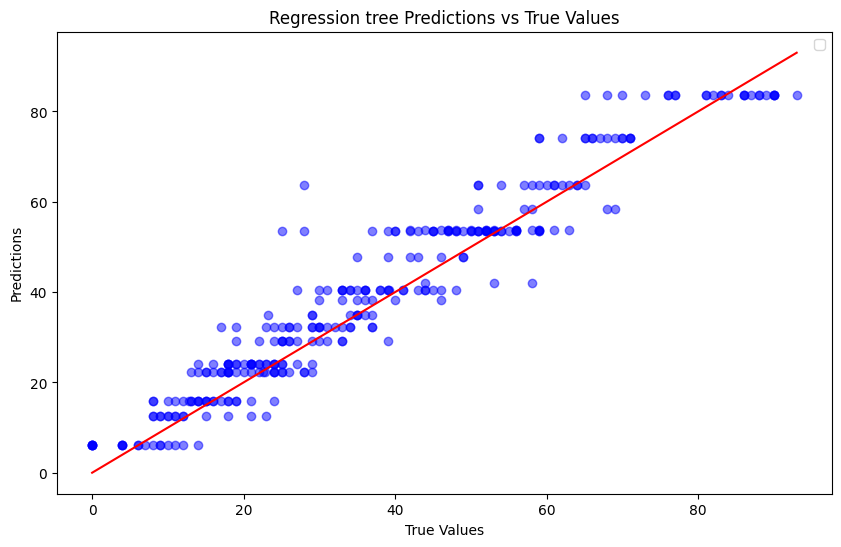

In [28]:
# Evaluating pruned regression tree
evaluate_and_plot_model(best_regressor, X_train_scaled, y_train, X_test_scaled, y_test, "Regression tree")

## Model #2: LASSO Regressions

### LASSO regressions, tuned

In [29]:
# Finding optimal parameters

# Define parameter grid
param_grid = {
    'alpha': np.arange(-10, 10, 5)  # Range of alpha values to search
}

# Initialize Lasso regression model
lasso = Lasso()

# Perform grid search cross-validation
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Initialize Lasso regression with the best hyperparameters
best_lasso = Lasso(**best_params)

# Fit the model
best_lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = best_lasso.predict(X_test_scaled)

# Calculate Mean Squared Error
print("R-squared:", r2_score(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))

c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.148e+04, tolerance: 4.590e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i

R-squared: 0.9225291768748437
Mean Absolute Error (MAE): 4.830263265346194
Mean Squared Error (MSE): 37.81157545323788
Root Mean Squared Error (RMSE): 6.149111761322759


c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e+04, tolerance: 5.742e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\samue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e+04, tolerance: 5.742e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i


Lasso Regression Training Set Performance:
R-squared: 0.9454564761023523
Mean Absolute Error (MAE): 3.5636324395193926
Mean Squared Error (MSE): 25.52617876837275
Root Mean Squared Error (RMSE): 5.05234388857021

Lasso Regression Test Set Performance:
R-squared: 0.9225291768748437
Mean Absolute Error (MAE): 4.830263265346194
Mean Squared Error (MSE): 37.81157545323788
Root Mean Squared Error (RMSE): 6.149111761322759


C:\Users\samue\AppData\Local\Temp\ipykernel_16248\439881147.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


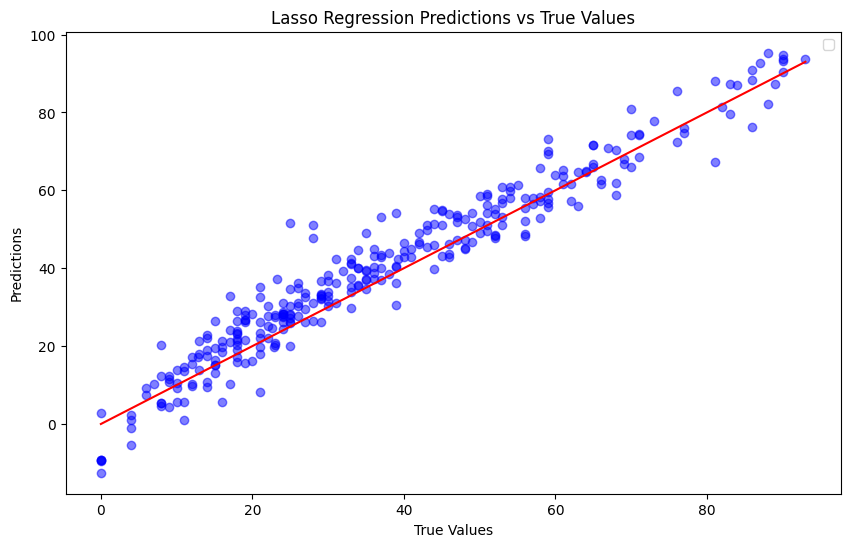

In [30]:
# Evaluating and fitting tuned lASSO regression model
evaluate_and_plot_model(best_lasso, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso Regression")

In [38]:
# Feature importance
for i, importance in enumerate(best_lasso.coef_):
    print(f"Feature {i}: {importance}")

Feature 0: 4.952174427863766
Feature 1: 1.1312446440033623
Feature 2: 0.7437640638267577
Feature 3: -7.850070724596892
Feature 4: 1.5568207842289565
Feature 5: 0.22664482039454079
Feature 6: 2.6149289737213675
Feature 7: 4.336056605189156
Feature 8: 2.8164939510263673
Feature 9: -4.653181092298517
Feature 10: -5.809310758211428
Feature 11: 5.530641569176583
Feature 12: 2.746843024529421
Feature 13: -4.8662119433225035
Feature 14: -5.776987855731874
Feature 15: -3.387163109582836
Feature 16: 8.495615271320107
Feature 17: -13.537450430426704
Feature 18: 3.3855793232284594
Feature 19: 0.49483400993568816
Feature 20: 13.35496222217556
Feature 21: -6.48118191571223
Feature 22: -0.5473438979663373
Feature 23: -1.4901826656324224
Feature 24: -0.9233168449415552
Feature 25: -6.543346755425823
Feature 26: -2.7077032510845442
Feature 27: -1.4764803374025346
Feature 28: 2.9501285868910263
Feature 29: -1.2318397215691994
Feature 30: 2.0798766062762857
Feature 31: 0.0
Feature 32: 0.2117434292556013

## Model #3: XGBoost

### XGBoost, tuned

In [ ]:
# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=10)

# Define parameter grid for pruning
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Initialize XGBoost regressor with the best hyperparameters
best_xgb_reg = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=10)

# Fit the model
best_xgb_reg.fit(X_train_final, y_train)

# Predict on the test set
y_pred = best_xgb_reg.predict(X_test_scaled)

# Best parameters
print("Best Parameters:", best_params)


Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 1.0}



XGBoost Regressor Training Set Performance:
R-squared: 0.9998649839779339
Mean Absolute Error (MAE): 0.18298415589528108
Mean Squared Error (MSE): 0.0631870269754232
Root Mean Squared Error (RMSE): 0.251370298514807

XGBoost Regressor Test Set Performance:
R-squared: 0.9332569335530679
Mean Absolute Error (MAE): 4.215082780478055
Mean Squared Error (MSE): 32.57562513388553
Root Mean Squared Error (RMSE): 5.70750603450277


C:\Users\samue\AppData\Local\Temp\ipykernel_45192\439881147.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


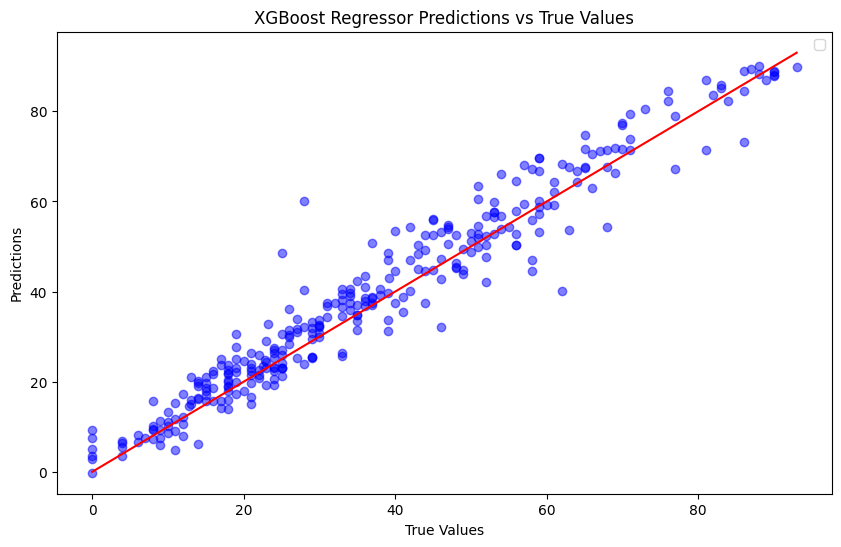

In [ ]:
# Evaluate and fitting tuned XGBoost model
evaluate_and_plot_model(best_xgb_reg, X_train_final, y_train, X_test_scaled, y_test, "XGBoost Regressor")